# Module

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# Load Data

In [3]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [4]:
# del train, test, data, clf
# gc.collect()

In [5]:
train = train_raw.copy()
test = test_raw.copy()

In [6]:
col_list = train.columns[2:]

In [7]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [8]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [9]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

test_real = test_pb.append(test_pv)

In [10]:
data = train.append(test_real)[['ID_code', 'target'] + col_list.tolist()]

# Extract Unique Value in All Data

In [11]:
unique_df = data[['ID_code']]
con_df = data[['ID_code']]

In [12]:
for col in tqdm(col_list):
    unique_df[col] = data[col].map(((data[col].value_counts() == 1) * 1).to_dict())
    con_df[col] = data[col].map((~(data[col].value_counts() == 1) * 1).to_dict())

In [13]:
for col in tqdm(col_list):
    data[col + '_unique'] = np.around(data[col] * unique_df[col], 4)
    data[col + '_con'] = np.around(data[col] * con_df[col], 4)

In [14]:
for col in tqdm(col_list):
    data.loc[data[col + '_unique']==0, col + '_unique'] = np.nan
    data.loc[data[col + '_con']==0, col + '_con'] = np.nan

In [15]:
for col in tqdm(col_list):
    data[col + '_con_multi_counts'] = data[col + '_con'] * data[col].map(data[col].value_counts().to_dict())

In [16]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_175_unique,var_175_con,var_176_unique,var_176_con,var_177_unique,var_177_con,var_178_unique,var_178_con,var_179_unique,var_179_con,var_180_unique,var_180_con,var_181_unique,var_181_con,var_182_unique,var_182_con,var_183_unique,var_183_con,var_184_unique,var_184_con,var_185_unique,var_185_con,var_186_unique,var_186_con,var_187_unique,var_187_con,var_188_unique,var_188_con,var_189_unique,var_189_con,var_190_unique,var_190_con,var_191_unique,var_191_con,var_192_unique,var_192_con,var_193_unique,var_193_con,var_194_unique,var_194_con,var_195_unique,var_195_con,var_196_unique,var_196_con,var_197_unique,var_197_con,var_198_unique,var_198_con,var_199_unique,var_199_con,var_0_con_multi_counts,var_1_con_multi_counts,var_2_con_multi_counts,var_3_con_multi_counts,var_4_con_multi_counts,var_5_con_multi_counts,var_6_con_multi_counts,var_7_con_multi_counts,var_8_con_multi_counts,var_9_con_multi_counts,var_10_con_multi_counts,var_11_con_multi_counts,var_12_con_multi_counts,var_13_con_multi_counts,var_14_con_multi_counts,var_15_con_multi_counts,var_16_con_multi_counts,var_17_con_multi_counts,var_18_con_multi_counts,var_19_con_multi_counts,var_20_con_multi_counts,var_21_con_multi_counts,var_22_con_multi_counts,var_23_con_multi_counts,var_24_con_multi_counts,var_25_con_multi_counts,var_26_con_multi_counts,var_27_con_multi_counts,var_28_con_multi_counts,var_29_con_multi_counts,var_30_con_multi_counts,var_31_con_multi_counts,var_32_con_multi_counts,var_33_con_multi_counts,var_34_con_multi_counts,var_35_con_multi_counts,var_36_con_multi_counts,var_37_con_multi_counts,var_38_con_multi_counts,var_39_con_multi_counts,var_40_con_multi_counts,var_41_con_multi_counts,var_42_con_multi_counts,var_43_con_multi_counts,var_44_con_multi_counts,var_45_con_multi_counts,var_46_con_multi_counts,var_47_con_multi_counts,var_48_con_multi_counts,var_49_con_multi_counts,var_50_con_multi_counts,var_51_con_multi_coun

# Model

In [17]:
train = data[~data.target.isna()]
test = data[data.target.isna()]

In [18]:
target = train['target']

In [22]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 5,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

In [23]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 3500)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.927675	valid_1's auc: 0.912918
[10000]	training's auc: 0.941267	valid_1's auc: 0.920628
[15000]	training's auc: 0.949227	valid_1's auc: 0.921705
[20000]	training's auc: 0.955925	valid_1's auc: 0.921671
Early stopping, best iteration is:
[18007]	training's auc: 0.953316	valid_1's auc: 0.921799
CV score: 0.92180 
fold n°1
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.927463	valid_1's auc: 0.914649
[10000]	training's auc: 0.941234	valid_1's auc: 0.920763
[15000]	training's auc: 0.949313	valid_1's auc: 0.921161
Early stopping, best iteration is:
[15127]	training's auc: 0.949493	valid_1's auc: 0.921192
CV score: 0.92119 
fold n°2
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.926203	valid_1's auc: 0.919356
[10000]	training's auc: 0.9398	valid_1's auc: 0.926729
[15000]	training's auc: 0.947915	valid_1's auc: 0.9

In [26]:
oof_temp = train[['ID_code']]
oof_temp['target'] = oof_lgb

te_temp = test[['ID_code']]
te_temp['target'] = predictions_lgb

oof_temp.to_csv('./data_temp/train_92274.csv', index=False)
te_temp.to_csv('./data_temp/test_92274.csv', index=False)

del oof_temp, te_temp
gc.collect()

0

In [30]:
oof_temp = train[['ID_code', 'target']]
oof_temp['pred'] = oof_lgb
oof_temp.to_csv('./data_temp/new_bbiggu_magic2.csv', index=False)

del oof_temp
gc.collect()

0

# oof Data

In [487]:
oof = pd.read_csv('./data_temp/new_bbiggu_magic2.csv')

bbiggu_0_id_code = oof[(oof.target == 0) & (oof.pred > 0.1)].ID_code
bbiggu_1_id_code = oof[(oof.target == 1) & (oof.pred < 0.1)].ID_code
normal_0_id_code = oof[(oof.target == 0) & (oof.pred < 0.1)].ID_code
normal_1_id_code = oof[(oof.target == 1) & (oof.pred > 0.1)].ID_code

In [529]:
normal_0_tr = data[data.ID_code.isin(normal_0_id_code)][:16923*4].copy()
normal_0_val = data[data.ID_code.isin(normal_0_id_code)][16923*4:].copy()
normal_1 = data[data.ID_code.isin(normal_1_id_code)].copy()
bbiggu_1 = data[data.ID_code.isin(bbiggu_1_id_code)].copy()

In [530]:
new_train = normal_0_tr.append(normal_1).sort_index()
target = new_train['target']

In [531]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_threads': 8
}

In [532]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

train_columns = [c for c in new_train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_train, target.values)):    
    trn_data = lgb.Dataset(new_train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(new_train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 90000
    clf_new = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    
    break

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.897787	valid_1's auc: 0.894185
[2000]	training's auc: 0.933992	valid_1's auc: 0.929982
[3000]	training's auc: 0.953304	valid_1's auc: 0.949265
[4000]	training's auc: 0.964019	valid_1's auc: 0.959913
[5000]	training's auc: 0.971443	valid_1's auc: 0.967662
[6000]	training's auc: 0.977172	valid_1's auc: 0.973572
[7000]	training's auc: 0.98132	valid_1's auc: 0.977833
[8000]	training's auc: 0.984541	valid_1's auc: 0.981175
[9000]	training's auc: 0.986993	valid_1's auc: 0.983784
[10000]	training's auc: 0.988964	valid_1's auc: 0.985778
[11000]	training's auc: 0.990574	valid_1's auc: 0.987591
[12000]	training's auc: 0.991993	valid_1's auc: 0.989146
[13000]	training's auc: 0.993021	valid_1's auc: 0.99023
[14000]	training's auc: 0.993915	valid_1's auc: 0.991237
[15000]	training's auc: 0.994637	valid_1's auc: 0.991986
[16000]	training's auc: 0.995307	valid_1's auc: 0.992784
[17000]	training's auc: 0.995874	val

# Post Proces

In [533]:
oof_test = oof[oof.ID_code.isin(normal_0_val.ID_code.append(bbiggu_1_id_code))].sort_index()

In [534]:
normal_0_val_df = normal_0_val[['ID_code']]
bbiggu_1_df = bbiggu_1[['ID_code']]

In [535]:
normal_0_val_df['new_pred'] = clf_new.predict(normal_0_val[train_columns], num_iteration=clf_new.best_iteration)
bbiggu_1_df['new_pred'] = clf_new.predict(bbiggu_1[train_columns], num_iteration=clf_new.best_iteration)

temp = normal_0_val_df.append(bbiggu_1_df).sort_index()

In [536]:
oof_test['new_pred'] = temp.new_pred

In [537]:
oof_test[['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.863122
new_pred,0.863122,1.000000


In [538]:
roc_auc_score(oof_test.target, oof_test.pred), roc_auc_score(oof_test.target, oof_test.pred * oof_test.new_pred), roc_auc_score(oof_test.target, oof_test.pred * oof_test.new_pred.rank())

(0.7820198692641739, 0.7860639714065095, 0.7853244720327238)

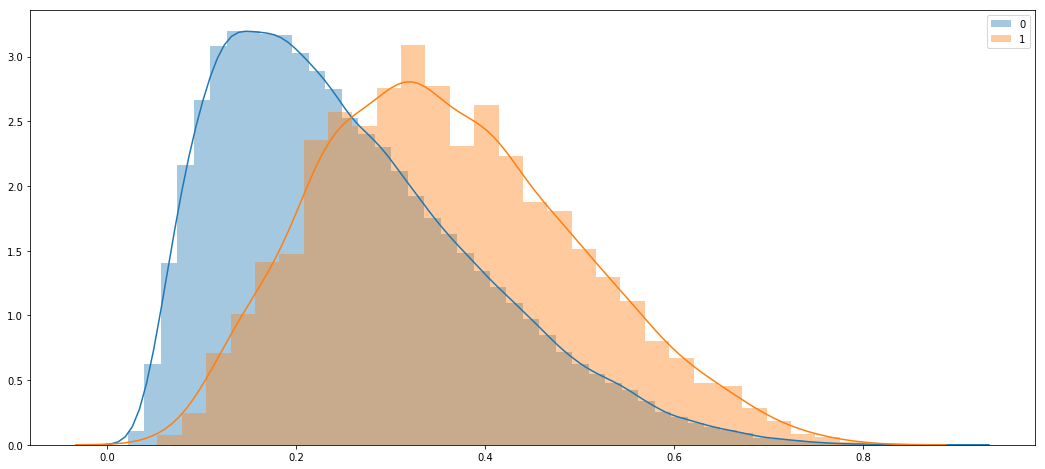

In [246]:
iteration = 8000
plt.figure(figsize=(18,8))
sns.distplot(clf_new.predict(normal_0_val[train_columns], num_iteration=iteration), label='0')
sns.distplot(clf_new.predict(bbiggu_1[train_columns], num_iteration=iteration), label='1')
plt.legend()

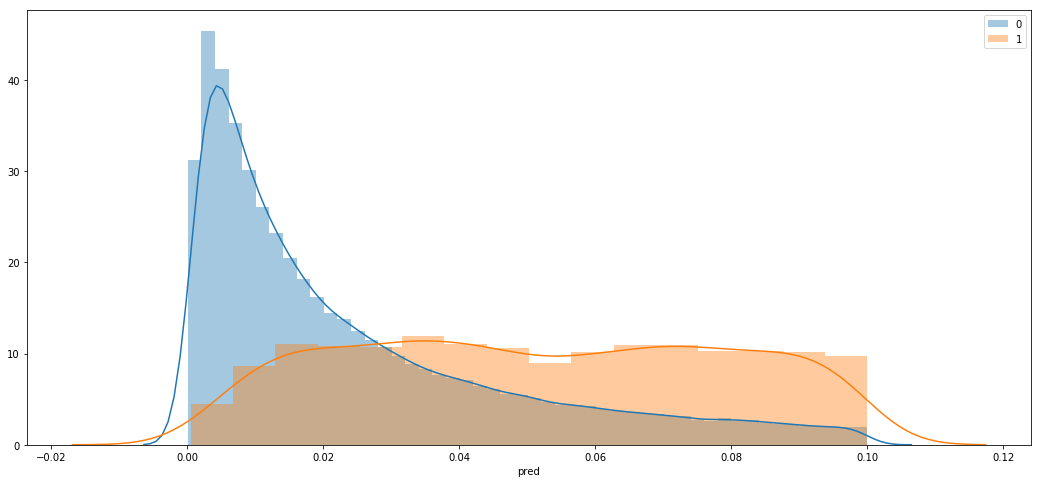

In [341]:
plt.figure(figsize=(18,8))
sns.distplot(oof_test[oof_test.target == 0].pred, label='0')
sns.distplot(oof_test[oof_test.target == 1].pred, label='1')
plt.legend()

In [366]:
t1 = oof_test[oof_test.pred < 0.028]
t2 = oof_test[oof_test.pred > 0.028]

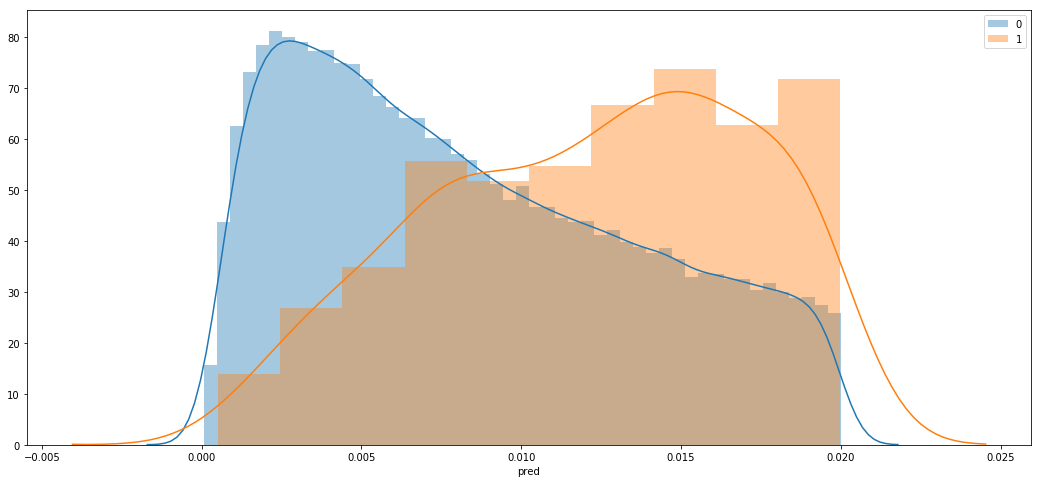

In [354]:
plt.figure(figsize=(18,8))
sns.distplot(t1[t1.target == 0].pred, label='0')
sns.distplot(t1[t1.target == 1].pred, label='1')
plt.legend()

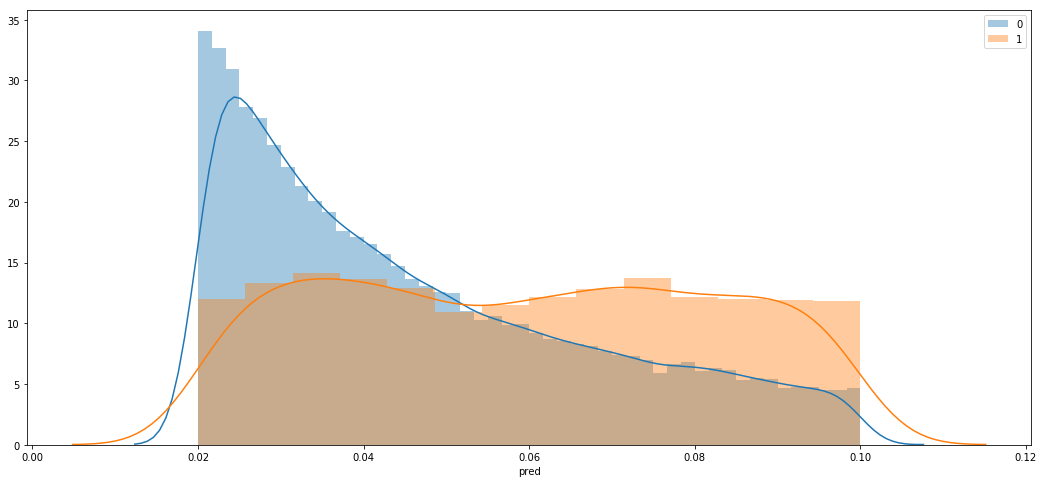

In [355]:
plt.figure(figsize=(18,8))
sns.distplot(t2[t2.target == 0].pred, label='0')
sns.distplot(t2[t2.target == 1].pred, label='1')
plt.legend()

In [379]:
roc_auc_score(t1.target, t1.pred), roc_auc_score(t1.target, t1.pred * (t1.new_pred + 1)), roc_auc_score(t1.target, t1.pred * t1.new_pred.rank())

(0.7043563876684081, 0.7064446428601455, 0.7101016291946844)

In [368]:
roc_auc_score(t2.target, t2.pred), roc_auc_score(t2.target, t2.pred * t2.new_pred), roc_auc_score(t2.target, t2.pred * t2.new_pred.rank())

(0.6334818636606555, 0.6327271828174961, 0.6320155186092915)

In [429]:
t1['final'] = t1.pred * t1.new_pred.rank()
t1['final'] = (t1['final'] - t1['final'].min()) * 0.0325 / (t1['final'].max() -t1['final'].min())
t2['final'] = t2.pred
t3 = t1.append(t2).sort_index()

In [430]:
roc_auc_score(t3.target, t3.final)

0.7831307560763037

In [266]:
t1[t1.target == 1][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.682368
new_pred,0.682368,1.000000


In [267]:
t1[t1.target == 0][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.791083
new_pred,0.791083,1.000000


In [270]:
t2[t2.target == 1][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.634485
new_pred,0.634485,1.000000


In [271]:
t2[t2.target == 0][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.0000,0.6403
new_pred,0.6403,1.0000


In [555]:
unchange = oof[(~oof.ID_code.isin(normal_0_tr.ID_code))]
unchange = unchange[(~unchange.ID_code.isin(oof_test.ID_code))]
unchange['post_pred'] = unchange['pred']
unchange['post_pred_rank'] = unchange['pred'] + 100000

change = oof_test.copy()
change['post_pred'] = change.pred * change.new_pred
change['post_pred_rank'] = change.pred * change.new_pred.rank()
temp = change.append(unchange).sort_index()

In [556]:
roc_auc_score(temp.target, temp.pred), roc_auc_score(temp.target, temp.post_pred), roc_auc_score(temp.target, temp.post_pred_rank)

(0.8968258842428717, 0.8973038217360192, 0.8972164266939425)

# sub

In [579]:
te_temp = test[['ID_code']]
te_temp['pred'] = predictions_lgb # 922짜리

In [580]:
temp = te_temp[te_temp.pred < 0.1].copy()
temp_data = data[data.ID_code.isin(temp.ID_code)]

In [581]:
temp['new_pred'] = clf_new.predict(temp_data[train_columns], num_iteration=clf_new.best_iteration)

In [582]:
temp['post_pred'] = temp['pred'] * temp['new_pred']

In [583]:
te_temp.loc[te_temp.ID_code.isin(temp.ID_code), 'pred'] = temp['post_pred']

In [584]:
te_temp.columns = ['ID_code', 'target']

In [585]:
sub = pd.read_csv('./data/sample_submission.csv')
unchange = sub[~sub.ID_code.isin(te_temp.ID_code)]
sub = te_temp[['ID_code', 'target']].append(unchange).sort_index()

In [601]:
te_temp.sort_index()

,ID_code,target,pred
3,test_3,1.161657e-01,0.116166
7,test_7,7.116388e-03,0.066608
11,test_11,1.809062e-03,0.042273
15,test_15,8.876063e-04,0.033467
16,test_16,4.116086e-01,0.411609
17,test_17,3.030695e-04,0.018760
18,test_18,1.087449e-02,0.054083
20,test_20,5.049735e-01,0.504973
21,test_21,4.854969e-03,0.040384
22,test_22,1.479836e-04,0.012507


In [599]:
sub

,ID_code,target
0,test_0,0.000000e+00
1,test_1,0.000000e+00
2,test_2,0.000000e+00
3,test_3,1.161657e-01
4,test_4,0.000000e+00
5,test_5,0.000000e+00
6,test_6,0.000000e+00
7,test_7,7.116388e-03
8,test_8,0.000000e+00
9,test_9,0.000000e+00


In [586]:
te_temp['pred'] = predictions_lgb

In [592]:
sub.to_csv('./data/lgb_cv_922_post.csv', index=False)